In [9]:
import glob
import contextily
import meteostat
import shapely
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import matplotlib.lines as mlines
from datetime import datetime

from utils.data_download import try_download_visual_crossing_data_and_save_to_csv
from utils.data_transformation import tabularise_data_by_season_and_area
from utils.latex import LatexHelpers


def to_meteostat_point(point: shapely.Point, alt: int = None) -> meteostat.Point:
    return meteostat.Point(point.y, point.x, alt)

In [10]:
polygons_path = "../data/aux/SAIS_areaPolygons.geojson"

gdf_areas = gpd.read_file(polygons_path)

# gdf.to_crs(epsg=27700, inplace=True)
# gdf["area (km^2)"] = gdf.area / 1000000
gdf_areas["centroid"] = gdf_areas.centroid

gdf_dict = gdf_areas.set_index("name").to_dict("index")

In [11]:
stations_visualcrossing = pd.read_csv(
    "../data/aux/stations_VisualCrossing_Scotland_subset.csv"
)
stations_visualcrossing = gpd.GeoDataFrame(
    stations_visualcrossing,
    geometry=gpd.points_from_xy(
        stations_visualcrossing.longitude, stations_visualcrossing.latitude
    ),
)


centroid_creag_meagaidh = gdf_dict["Creag Meagaidh"]["centroid"]

retriever_meteostat = meteostat.Stations().nearby(
    centroid_creag_meagaidh.y, centroid_creag_meagaidh.x
)
stations_meteostat = retriever_meteostat.fetch(len(stations_visualcrossing))
stations_meteostat = gpd.GeoDataFrame(
    stations_meteostat,
    geometry=gpd.points_from_xy(
        stations_meteostat.longitude, stations_meteostat.latitude
    ),
)

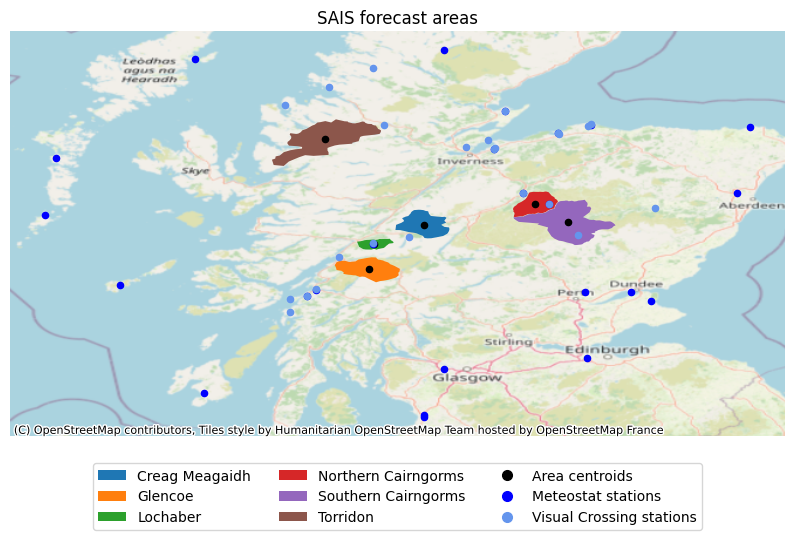

In [12]:
cmap = colormaps["tab10"]

fig, ax = plt.subplots(figsize=(10, 10))
pmarks = []
i = 0
for label, data in gdf_areas.groupby("name"):
    color = cmap(i)
    data.plot(ax=ax, color=color)
    pmarks.append(Patch(facecolor=color, label=label))
    i += 1

c_centroid = "black"
c_meteostat = "blue"
c_visualcrossing = "cornflowerblue"
dot_size = 20
gdf_areas.geometry.centroid.plot(ax=ax, color=c_centroid, markersize=dot_size)
stations_meteostat.geometry.plot(ax=ax, color=c_meteostat, markersize=dot_size)
stations_visualcrossing.geometry.plot(
    ax=ax, color=c_visualcrossing, markersize=dot_size
)

handles, _ = ax.get_legend_handles_labels()
pmarks.append(
    mlines.Line2D(
        [],
        [],
        color=c_centroid,
        marker="o",
        linestyle="None",
        markersize=7,
        label="Area centroids",
    )
)
pmarks.append(
    mlines.Line2D(
        [],
        [],
        color=c_meteostat,
        marker="o",
        linestyle="None",
        markersize=7,
        label="Meteostat stations",
    )
)
pmarks.append(
    mlines.Line2D(
        [],
        [],
        color=c_visualcrossing,
        marker="o",
        linestyle="None",
        markersize=7,
        label="Visual Crossing stations",
    )
)

ax.legend(
    handles=[*handles, *pmarks], loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3
)

contextily.add_basemap(ax, crs=gdf_areas.crs.to_string())
plt.title("SAIS forecast areas")
plt.axis("off")
plt.show()

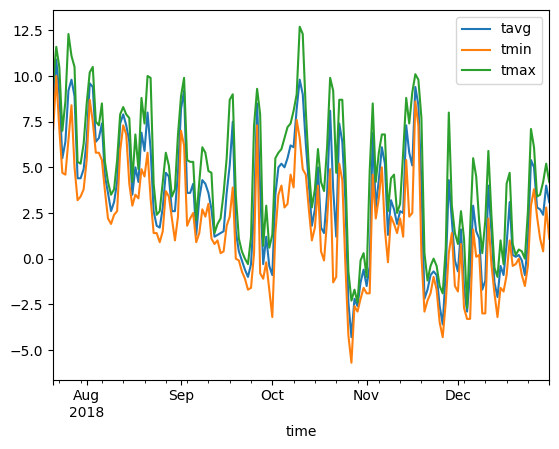

24

In [13]:
# Import Meteostat library and dependencies

import matplotlib.pyplot as plt
from meteostat import Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
region = to_meteostat_point(gdf_dict["Creag Meagaidh"]["centroid"])

# Get daily data for 2018
data = Daily(region, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()
len(stations_meteostat)

## Visual Crossing data download

In [14]:
gdf_summits = gpd.read_file("../data/aux/SAIS_summits.geojson")
df_seasons = pd.read_csv("../data/aux/SAIS_seasons.csv")
df_seasons["season_start"] = pd.to_datetime(df_seasons["season_start"])
df_seasons["season_end"] = pd.to_datetime(df_seasons["season_end"])


def collate_into_single_file(suffix: str, delete_source_files: bool, forecast: bool):
    df = pd.DataFrame()
    kind = "forecast" if forecast else "observed"

    for name in gdf_summits["name"].unique():
        files = glob.glob(
            f"../data/proprietary/weather/visual_crossing/{name.lower().replace(' ', '_')}*{kind}**{suffix}*"
        )
        for file in files:
            df_partial = pd.read_csv(file)
            df_partial["Area"] = name
            df = pd.concat([df, df_partial], ignore_index=True)
            if delete_source_files:
                os.remove(file)

    if len(df) > 0:
        df.to_csv(
            f"../data/proprietary/weather/visual_crossing/weather_{kind}_{suffix}.csv",
            index=False,
        )


# long-running, API limits
rerun = False

if rerun:
    for forecast in [True]:
        for hourly in [True]:
            for _, season in df_seasons.iterrows():
                start = season["season_start"]
                end = season["season_end"]
                for _, area in gdf_summits.iterrows():
                    try_download_visual_crossing_data_and_save_to_csv(
                        area_name=area["name"],
                        latitute=area.geometry.y,
                        longitude=area.geometry.x,
                        start=start,
                        end=end,
                        forecast=forecast,
                        hourly=hourly,
                    )

            if not hourly:
                collate_into_single_file(
                    suffix="days", delete_source_files=True, forecast=forecast
                )
                continue
            # hourly
            collate_into_single_file(
                suffix="hours", delete_source_files=True, forecast=forecast
            )
            file_name = f"../data/proprietary/weather/visual_crossing/weather_{"forecast" if forecast else "observed"}_hours.csv"
            # seasons containing the March time change have 1 hour less than expected, backfill with later hour
            df_hours = pd.read_csv(file_name)
            df_hours["datetime"] = pd.to_datetime(df_hours["datetime"])

            df_hours.sort_values(
                by=["Area", "datetime"], inplace=True, ignore_index=True
            )
            df_hours["time_diff_hours"] = (
                df_hours["datetime"].diff().dt.total_seconds() / 3600
            )
            indices_with_time_diff_2h = df_hours[df_hours["time_diff_hours"] == 2].index
            for idx in indices_with_time_diff_2h:
                row = df_hours.loc[idx].copy()
                row["datetime"] -= pd.Timedelta(hours=1)
                df_hours.loc[len(df_hours)] = row

            df_hours.sort_values(
                by=["Area", "datetime"], inplace=True, ignore_index=True
            )
            df_hours.drop(columns=["time_diff_hours"], inplace=True)

            df_hours.to_csv(file_name)

In [15]:
rerun = False

# long-running
if rerun:
    # tabularise weather_observed_days
    max_lookback = round(df_seasons["day_diff"].mean())

    df_days = pd.read_csv(
        "../data/proprietary/weather/visual_crossing/weather_observed_days.csv"
    )
    df_days["preciptype_snow"] = df_days["preciptype"].apply(
        lambda x: 1 if "snow" in str(x).lower() else 0
    )
    df_days["preciptype_rain"] = df_days["preciptype"].apply(
        lambda x: 1 if "rain" in str(x).lower() else 0
    )

    # data cleanup
    df_days.loc[df_days["windspeed50"] == 0, "winddir50"] = 0
    df_days.drop(
        columns=[
            "preciptype",
            "et0",
            "soiltemp01",
            "soiltemp04",
            "soiltemp10",
            "soiltemp20",
            "soilmoisture01",
            "soilmoisture04",
            "soilmoisture10",
            "soilmoisture20",
            "winddir80",
            "winddir100",
            "ghiradiation",
            "dniradiation",
            "difradiation",
            "gtiradiation",
        ],
        inplace=True,
    )
    df_days.fillna(0, inplace=True)
    df_days.rename(columns={"datetime": "Date"}, inplace=True)

    dependent_variables = list(set(df_days.columns.tolist()) - set(["Area", "Date"]))

    df_days_tab = tabularise_data_by_season_and_area(
        seasons=df_seasons,
        data=df_days,
        dependent_variables=dependent_variables,
        season_max_lookback=max_lookback,
        include_seasons_day=True,
        skip_missing_days=True,
    )

    df_days_tab.to_csv(
        "../data/proprietary/weather/visual_crossing/weather_observed_days_tabularised.csv",
        index=False,
    )

In [16]:
df_hours = pd.read_csv("../data/proprietary/weather/visual_crossing/weather_observed_hours.csv")


def cleanup_hourly_data(df_hours: pd.DataFrame):

    df_hours["preciptype_snow"] = df_hours["preciptype"].apply(
        lambda x: 1 if "snow" in str(x).lower() else 0
    )
    df_hours["preciptype_rain"] = df_hours["preciptype"].apply(
        lambda x: 1 if "rain" in str(x).lower() else 0
    )

    df_hours.loc[df_hours["windspeed50"] == 0, "winddir50"] = 0

    df_hours.drop(
        columns=[
            "preciptype",
            "et0",
            "soiltemp01",
            "soiltemp04",
            "soiltemp10",
            "soiltemp20",
            "soilmoisture01",
            "soilmoisture04",
            "soilmoisture10",
            "soilmoisture20",
            "winddir80",
            "winddir100",
            "ghiradiation",
            "dniradiation",
            "difradiation",
            "gtiradiation",
            "windspeed50",
            "winddir50",
            "windspeed80",
            "windspeed100",
            "snow",
            "snowdepth",
            "windgust",
        ],
        inplace=True,
    )
    df_hours.fillna(0, inplace=True)

In [ ]:
rerun = False

if rerun:
    df_hours = pd.read_csv(
        "../data/proprietary/weather/visual_crossing/weather_observed_hours.csv"
    )
    cleanup_hourly_data(df_hours)
    df_days_tab = pd.read_csv(
        "../data/proprietary/weather/visual_crossing/weather_observed_days_tabularised.csv"
    )
    day_indices_to_replace_with_daily_data = [0, 1]

    for idx in day_indices_to_replace_with_daily_data:
        columns_ending_with_idx = [
            col for col in df_days_tab.columns if col.endswith(f"_{idx}")
        ]

        for col in columns_ending_with_idx:
            base_col = col[: -(len(str(idx)) + 1)]
            if not base_col in df_hours.columns:
                continue
            hours_col = df_hours[base_col]
            hours_matrix = hours_col.values.reshape(-1, 24)
            hours_col_names = [f"{col}_{i}" for i in range(24)]
            df_days_tab.drop(columns=col, inplace=True)
            df_days_tab = pd.concat(
                [
                    df_days_tab.reset_index(drop=True),
                    pd.DataFrame(hours_matrix, columns=hours_col_names).reset_index(
                        drop=True
                    ),
                ],
                axis=1,
            )

    df_days_tab = df_days_tab.reindex(sorted(df_days_tab.columns), axis=1)
    
    LatexHelpers.save_text_snippet(
        f"{df_days_tab.shape[1]-4:,}", "weather_idependent_variable_dimension", path="../tex/assets/snippets")
    
    df_days_tab.to_csv(
        "../data/proprietary/weather/visual_crossing/weather_tabularised_48_hours_then_days.csv"
    )